# FIT3182 - Assignment

Name : Ko Ko Win 
<br>
ID : 31842305
<br>
Email: kwin0005@student.monash.edu 

## PART A 

### Task 1.MongoDB Data Model

Justification for choosing model: 

After observing the 2 datasets hotspot_historic.csv and climate_historic.csv it can be seen that climate_historic produced one data per day whereas hotspot_historic produced several data per day at different times. Furthermore, Date can be merged with the 2 datasets since it is a common attribute in both datasets. Thus, we can model one-to-many relationships since one climate_histroic data can have many hotspot_historic data.

For these 2 datasets, I have chosen the embedded modelling approach. It is because MongoDB does not support normalisation hence JOIN operation can be complex and costly. Therefore by using embedding approach, read operation will be faster and more efficient to perform query since it is merged into a single document which reduces the number of read operations. Moreover, there is no need for JOIN operation since we are using an embedded approach. However, the embedded approach also has its own limitations such as the risk of exceeding the threshold memory limit.

Example of Data Model: 

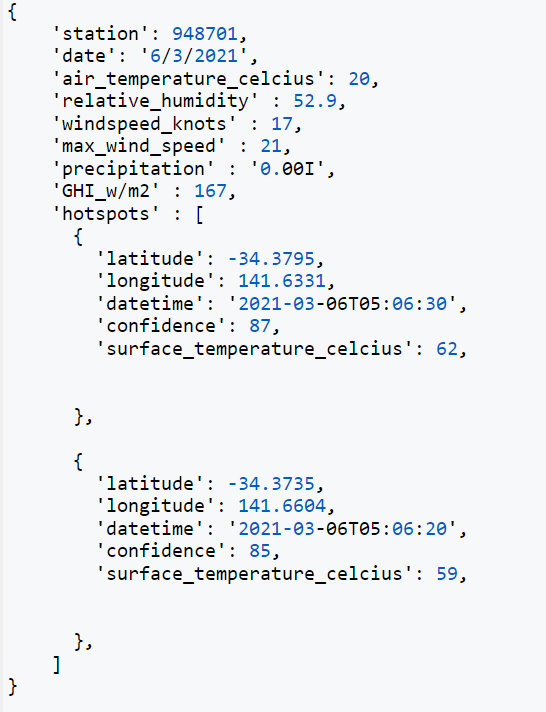

### Task 2. Query with MongoDB

### Q1)

In [32]:
import pandas as pd
import pymongo 
from pymongo import MongoClient 
import json 
from datetime import datetime
from pprint import pprint

In [33]:
#1 Connect on default host and port 
client = MongoClient() 
db = client.fit3182_assignment_db 
collection = db.climate

In [34]:
# Delete all documents from collection
collection.drop()

In [35]:
#Read csv 
hotspot = pd.read_csv("hotspot_historic.csv")
climate = pd.read_csv("climate_historic.csv")

In [38]:
 #remove trailing spaces in column header 
climate.columns = climate.columns.str.replace(' ', '')

In [39]:
#split precipitation column based on the flag for later query 
climate["precipitation_flag"] = climate["precipitation"].str[-1]

In [40]:
#split the precipitation column based on the value for the later query 
climate["precipitation_value"] = climate["precipitation"].str[0:5]

In [42]:
my_collection = []
for index, row in climate.iterrows():
    my_docs = {}
    
    #add data into climate dictionary (my_docs)
    my_docs['station'] = int(row['station']) 
    my_docs['date'] = datetime.strptime(row['date'], "%d/%m/%y")
    my_docs['air_temperature_celcius'] = int(row['air_temperature_celcius'])
    my_docs['relative_humidity'] = float(row['relative_humidity']) 
    my_docs['windspeed_knots'] = float(row['windspeed_knots']) 
    my_docs['max_wind_speed'] = float(row['max_wind_speed']) 
    my_docs['precipitation'] = str(row['precipitation']) 
    my_docs['GHI_w/m2'] = int(row['GHI_w/m2'])
    my_docs["precipitation_flag"] = str(row["precipitation_flag"]) 
    my_docs["precipitation_value"] = float(row["precipitation_value"])
    
    #convert to datetime to string 
    h_date = my_docs["date"].strftime('%d/%m/%Y')
    
    #search for matching date with hotspot data
    my_hotspots = hotspot[hotspot["date"] == h_date]
    
    #If there is a match  then append to climate document (my_docs)
    if len(my_hotspots) != 0: 
        my_docs['hotspots'] = []
        for index, row in my_hotspots.iterrows(): 
            h_docs = {}
            
            #add data into hotspot dictionary (h_docs)
            h_docs['latitude'] = float(row['latitude'])
            h_docs['longitude'] = float(row['longitude']) 
            h_docs['datetime'] = datetime.strptime(row['datetime'], "%Y-%m-%dT%H:%M:%S")
            h_docs['confidence'] = int(row['confidence']) 
            h_docs['surface_temperature_celcius'] = int(row['surface_temperature_celcius'])
            
            #add data to array with key "hotspots" 
            my_docs['hotspots'].append(h_docs)
    
    my_collection.append(my_docs)
    

#Insert multiples documents into MongoDB
collection.insert_many(my_collection)

### Q2) 

#### a) Find climate data on 12th December 2021

In [43]:
pprint(collection.find_one({'date': datetime(2021, 12, 12, 0, 0)}))

{'GHI_w/m2': 156,
 '_id': ObjectId('627f70c5e7c5c5fe65ec2598'),
 'air_temperature_celcius': 19,
 'date': datetime.datetime(2021, 12, 12, 0, 0),
 'hotspots': [{'confidence': 53,
               'datetime': datetime.datetime(2021, 12, 12, 0, 45, 38),
               'latitude': -37.903,
               'longitude': 145.25,
               'surface_temperature_celcius': 44}],
 'max_wind_speed': 12.0,
 'precipitation': ' 0.00I',
 'precipitation_flag': 'I',
 'precipitation_value': 0.0,
 'relative_humidity': 55.3,
 'station': 948702,
 'windspeed_knots': 6.2}


#### b)  Find latitude, longitude, confidence,  surface_temperature_celcius when the surface_temperature_celcius is between 65 degree and 100 degree.

In [44]:
results = collection.aggregate([{"$unwind" : "$hotspots"}, 
                               {"$match" : {"hotspots.surface_temperature_celcius" :{"$gt":65, "$lt":100}}},
                               {"$project" : {"_id" : 0, "hotspots.latitude" : 1, "hotspots.longitude" : 1, 
                                              "hotspots.confidence" :1,
                                             "hotspots.surface_temperature_celcius" : 1}}
                               ])

for result in results: 
    pprint(result)

{'hotspots': {'confidence': 94,
              'latitude': -37.2284,
              'longitude': 147.9187,
              'surface_temperature_celcius': 73}}
{'hotspots': {'confidence': 97,
              'latitude': -37.6572,
              'longitude': 142.0703,
              'surface_temperature_celcius': 80}}
{'hotspots': {'confidence': 84,
              'latitude': -37.0193,
              'longitude': 148.1459,
              'surface_temperature_celcius': 71}}
{'hotspots': {'confidence': 100,
              'latitude': -37.4229,
              'longitude': 147.02700000000002,
              'surface_temperature_celcius': 99}}
{'hotspots': {'confidence': 80,
              'latitude': -37.0055,
              'longitude': 148.1582,
              'surface_temperature_celcius': 68}}
{'hotspots': {'confidence': 85,
              'latitude': -37.4128,
              'longitude': 147.0242,
              'surface_temperature_celcius': 98}}
{'hotspots': {'confidence': 90,
              'latitude': -

{'hotspots': {'confidence': 100,
              'latitude': -36.345,
              'longitude': 143.4256,
              'surface_temperature_celcius': 87}}
{'hotspots': {'confidence': 90,
              'latitude': -36.7032,
              'longitude': 144.0992,
              'surface_temperature_celcius': 66}}
{'hotspots': {'confidence': 96,
              'latitude': -36.3402,
              'longitude': 141.7429,
              'surface_temperature_celcius': 77}}
{'hotspots': {'confidence': 85,
              'latitude': -36.5023,
              'longitude': 143.6038,
              'surface_temperature_celcius': 66}}
{'hotspots': {'confidence': 90,
              'latitude': -36.8616,
              'longitude': 142.8025,
              'surface_temperature_celcius': 78}}
{'hotspots': {'confidence': 90,
              'latitude': -38.0372,
              'longitude': 146.0616,
              'surface_temperature_celcius': 67}}
{'hotspots': {'confidence': 94,
              'latitude': -38.049,
   

#### c) Find date, surface temperature, air temperature, relative humidity and max windspeed on 15 December and 16 December. 

In [45]:
results = collection.find({"date": {"$in":[datetime(2021, 12, 15, 0, 0),datetime(2021, 12, 16, 0, 0)]}}, 
                          {"_id": 0, "date": 1, "hotspots.surface_temperature_celcius" : 1,"air_temperature_celcius": 1, 
                           "relative_humidity": 1, "max_wind_speed": 1}) 

for result in results: 
    pprint({
        'air_temperature_celcius' : result['air_temperature_celcius'],
        'date' : result["date"].strftime("%d/%m/%Y"), 
        'hotspots' : result['hotspots'], 
        'max_wind_speed' : result['max_wind_speed'],
        'relative_humidity' : result['relative_humidity']
        
    })

{'air_temperature_celcius': 18,
 'date': '15/12/2021',
 'hotspots': [{'surface_temperature_celcius': 42},
              {'surface_temperature_celcius': 36},
              {'surface_temperature_celcius': 38},
              {'surface_temperature_celcius': 40}],
 'max_wind_speed': 14.0,
 'relative_humidity': 52.0}
{'air_temperature_celcius': 18,
 'date': '16/12/2021',
 'hotspots': [{'surface_temperature_celcius': 43},
              {'surface_temperature_celcius': 33},
              {'surface_temperature_celcius': 54},
              {'surface_temperature_celcius': 73},
              {'surface_temperature_celcius': 55},
              {'surface_temperature_celcius': 75},
              {'surface_temperature_celcius': 55},
              {'surface_temperature_celcius': 66},
              {'surface_temperature_celcius': 56},
              {'surface_temperature_celcius': 60},
              {'surface_temperature_celcius': 73},
              {'surface_temperature_celcius': 48},
              {'surf

#### d) Find datetime, air temperature, surface temperature and confidence when confidence is betweeen 80 and 100. 

In [61]:
results = collection.find({"hotspots.confidence" : {"$gt":80, "$lt":100}},
                         {"_id": 0, "hotspots.datetime": 1, "air_temperature_celcius": 1, 
                         "hotspots.surface_temperature_celcius": 1, "hotspots.confidence": 1})

for result in results: 
    pprint(result)

{'air_temperature_celcius': 19,
 'hotspots': [{'confidence': 100,
               'datetime': datetime.datetime(2021, 3, 10, 4, 48, 40),
               'surface_temperature_celcius': 105},
              {'confidence': 100,
               'datetime': datetime.datetime(2021, 3, 10, 4, 46, 20),
               'surface_temperature_celcius': 109},
              {'confidence': 94,
               'datetime': datetime.datetime(2021, 3, 10, 4, 45, 30),
               'surface_temperature_celcius': 73},
              {'confidence': 97,
               'datetime': datetime.datetime(2021, 3, 10, 4, 45, 30),
               'surface_temperature_celcius': 80},
              {'confidence': 81,
               'datetime': datetime.datetime(2021, 3, 10, 4, 43, 50),
               'surface_temperature_celcius': 55},
              {'confidence': 55,
               'datetime': datetime.datetime(2021, 3, 10, 4, 43),
               'surface_temperature_celcius': 42},
              {'confidence': 54,
           

               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
               'surface_temperature_celcius': 50},
              {'confidence': 100,
               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
               'surface_temperature_celcius': 115},
              {'confidence': 100,
               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
               'surface_temperature_celcius': 89},
              {'confidence': 76,
               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
               'surface_temperature_celcius': 49},
              {'confidence': 91,
               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
               'surface_temperature_celcius': 68},
              {'confidence': 80,
               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
               'surface_temperature_celcius': 54},
              {'confidence': 84,
               'datetime': datetime.datetime(2021, 4, 13, 4, 26, 50),
   

               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 114},
              {'confidence': 75,
               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 49},
              {'confidence': 87,
               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 62},
              {'confidence': 69,
               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 45},
              {'confidence': 78,
               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 51},
              {'confidence': 62,
               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
               'surface_temperature_celcius': 43},
              {'confidence': 64,
               'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
     

               'datetime': datetime.datetime(2021, 5, 10, 4, 11, 10),
               'surface_temperature_celcius': 68},
              {'confidence': 63,
               'datetime': datetime.datetime(2021, 5, 10, 4, 11, 10),
               'surface_temperature_celcius': 42},
              {'confidence': 81,
               'datetime': datetime.datetime(2021, 5, 10, 4, 11, 10),
               'surface_temperature_celcius': 55},
              {'confidence': 77,
               'datetime': datetime.datetime(2021, 5, 10, 4, 11, 10),
               'surface_temperature_celcius': 50},
              {'confidence': 64,
               'datetime': datetime.datetime(2021, 5, 10, 4, 11, 10),
               'surface_temperature_celcius': 42},
              {'confidence': 67,
               'datetime': datetime.datetime(2021, 5, 10, 4, 10, 10),
               'surface_temperature_celcius': 43},
              {'confidence': 59,
               'datetime': datetime.datetime(2021, 5, 10, 4, 10),
          

              {'confidence': 100,
               'datetime': datetime.datetime(2021, 10, 26, 13, 30, 31),
               'surface_temperature_celcius': 53},
              {'confidence': 67,
               'datetime': datetime.datetime(2021, 10, 26, 4, 4, 53),
               'surface_temperature_celcius': 42},
              {'confidence': 69,
               'datetime': datetime.datetime(2021, 10, 26, 4, 4, 53),
               'surface_temperature_celcius': 44}]}
{'air_temperature_celcius': 22,
 'hotspots': [{'confidence': 62,
               'datetime': datetime.datetime(2021, 10, 27, 4, 47, 31),
               'surface_temperature_celcius': 44},
              {'confidence': 78,
               'datetime': datetime.datetime(2021, 10, 27, 4, 47, 31),
               'surface_temperature_celcius': 51},
              {'confidence': 86,
               'datetime': datetime.datetime(2021, 10, 27, 4, 47, 31),
               'surface_temperature_celcius': 60},
              {'confidence': 78,
    

#### e) find top 10 record with highest surface temperature. 

In [47]:
results = collection.aggregate([{"$unwind": "$hotspots"},
                               {"$sort": {"surface_temperature_celcius" : -1}},
                               {"$limit" : 10}])

for result in results: 
    pprint(result)

{'GHI_w/m2': 168,
 '_id': ObjectId('627f70c5e7c5c5fe65ec2485'),
 'air_temperature_celcius': 21,
 'date': datetime.datetime(2021, 3, 12, 0, 0),
 'hotspots': {'confidence': 94,
              'datetime': datetime.datetime(2021, 3, 12, 4, 33, 50),
              'latitude': -37.4157,
              'longitude': 147.0084,
              'surface_temperature_celcius': 105},
 'max_wind_speed': 11.1,
 'precipitation': ' 0.00G',
 'precipitation_flag': 'G',
 'precipitation_value': 0.0,
 'relative_humidity': 58.1,
 'station': 948701,
 'windspeed_knots': 5.3}
{'GHI_w/m2': 168,
 '_id': ObjectId('627f70c5e7c5c5fe65ec2485'),
 'air_temperature_celcius': 21,
 'date': datetime.datetime(2021, 3, 12, 0, 0),
 'hotspots': {'confidence': 84,
              'datetime': datetime.datetime(2021, 3, 12, 4, 29, 50),
              'latitude': -37.0193,
              'longitude': 148.1459,
              'surface_temperature_celcius': 71},
 'max_wind_speed': 11.1,
 'precipitation': ' 0.00G',
 'precipitation_flag': 'G',
 

#### f) Find number of each day. 
#### Reference: https://stackoverflow.com/questions/24201120/mongodb-the-argument-to-size-must-be-an-array-but-was-of-type-eoo-missing

In [48]:
results = collection.aggregate([{"$project" : {"date" : 1, "_id" : 0, "hotspot" : {"$size" :
                                                {"$ifNull" : ['$hotspots', []]}}}}])

for result in results: 
    pprint({
        "date" : result["date"].strftime("%d/%m/%Y"),
        "Fire Occurence" : result["hotspot"]
    })

{'Fire Occurence': 0, 'date': '31/12/2020'}
{'Fire Occurence': 0, 'date': '02/01/2021'}
{'Fire Occurence': 0, 'date': '03/01/2021'}
{'Fire Occurence': 0, 'date': '04/01/2021'}
{'Fire Occurence': 0, 'date': '05/01/2021'}
{'Fire Occurence': 0, 'date': '06/01/2021'}
{'Fire Occurence': 0, 'date': '07/01/2021'}
{'Fire Occurence': 0, 'date': '08/01/2021'}
{'Fire Occurence': 0, 'date': '09/01/2021'}
{'Fire Occurence': 0, 'date': '10/01/2021'}
{'Fire Occurence': 0, 'date': '11/01/2021'}
{'Fire Occurence': 0, 'date': '12/01/2021'}
{'Fire Occurence': 0, 'date': '13/01/2021'}
{'Fire Occurence': 0, 'date': '14/01/2021'}
{'Fire Occurence': 0, 'date': '15/01/2021'}
{'Fire Occurence': 0, 'date': '16/01/2021'}
{'Fire Occurence': 0, 'date': '17/01/2021'}
{'Fire Occurence': 0, 'date': '18/01/2021'}
{'Fire Occurence': 0, 'date': '19/01/2021'}
{'Fire Occurence': 0, 'date': '20/01/2021'}
{'Fire Occurence': 0, 'date': '21/01/2021'}
{'Fire Occurence': 0, 'date': '22/01/2021'}
{'Fire Occurence': 0, 'date': '2

#### g) Find the record of fire where the confidence is below 70

In [49]:
results = collection.aggregate([ 
    {"$unwind": "$hotspots"}, 
    {"$match" : {"hotspots.confidence" : {"$lt" : 70}}}, 
    {"$project" : {"_id" : 0, "hotspots" : 1}}])

for result in results: 
    pprint(result)

{'hotspots': {'confidence': 55,
              'datetime': datetime.datetime(2021, 3, 10, 4, 43),
              'latitude': -36.2544,
              'longitude': 148.0353,
              'surface_temperature_celcius': 42}}
{'hotspots': {'confidence': 54,
              'datetime': datetime.datetime(2021, 3, 10, 4, 42, 30),
              'latitude': -37.2197,
              'longitude': 147.9621,
              'surface_temperature_celcius': 43}}
{'hotspots': {'confidence': 56,
              'datetime': datetime.datetime(2021, 3, 13, 23, 58, 50),
              'latitude': -37.0286,
              'longitude': 148.155,
              'surface_temperature_celcius': 42}}
{'hotspots': {'confidence': 52,
              'datetime': datetime.datetime(2021, 3, 13, 12, 57),
              'latitude': -37.0316,
              'longitude': 148.1519,
              'surface_temperature_celcius': 35}}
{'hotspots': {'confidence': 52,
              'datetime': datetime.datetime(2021, 3, 15, 0, 42, 50),
          

              'longitude': 146.3329,
              'surface_temperature_celcius': 43}}
{'hotspots': {'confidence': 66,
              'datetime': datetime.datetime(2021, 4, 15, 4, 17, 30),
              'latitude': -36.8004,
              'longitude': 142.4415,
              'surface_temperature_celcius': 52}}
{'hotspots': {'confidence': 64,
              'datetime': datetime.datetime(2021, 4, 15, 4, 17, 30),
              'latitude': -36.8377,
              'longitude': 143.4624,
              'surface_temperature_celcius': 42}}
{'hotspots': {'confidence': 69,
              'datetime': datetime.datetime(2021, 4, 15, 4, 16),
              'latitude': -36.798,
              'longitude': 142.4482,
              'surface_temperature_celcius': 44}}
{'hotspots': {'confidence': 65,
              'datetime': datetime.datetime(2021, 4, 15, 4, 15, 40),
              'latitude': -36.6833,
              'longitude': 142.8296,
              'surface_temperature_celcius': 42}}
{'hotspots': {'confide

              'latitude': -38.0392,
              'longitude': 143.8842,
              'surface_temperature_celcius': 45}}
{'hotspots': {'confidence': 68,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -38.1719,
              'longitude': 143.0705,
              'surface_temperature_celcius': 44}}
{'hotspots': {'confidence': 69,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -38.0907,
              'longitude': 143.2362,
              'surface_temperature_celcius': 45}}
{'hotspots': {'confidence': 62,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -38.0278,
              'longitude': 143.4528,
              'surface_temperature_celcius': 43}}
{'hotspots': {'confidence': 64,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -37.9913,
              'longitude': 143.5272,
              'surface_temperat

{'hotspots': {'confidence': 64,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -36.7898,
              'longitude': 144.00799999999998,
              'surface_temperature_celcius': 46}}
{'hotspots': {'confidence': 67,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -36.9205,
              'longitude': 143.0889,
              'surface_temperature_celcius': 43}}
{'hotspots': {'confidence': 65,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -36.2283,
              'longitude': 146.3102,
              'surface_temperature_celcius': 42}}
{'hotspots': {'confidence': 51,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44, 50),
              'latitude': -36.7887,
              'longitude': 143.4841,
              'surface_temperature_celcius': 38}}
{'hotspots': {'confidence': 65,
              'datetime': datetime.datetime(2021, 4, 18, 4, 44

              'surface_temperature_celcius': 43}}
{'hotspots': {'confidence': 56,
              'datetime': datetime.datetime(2021, 5, 10, 4, 8, 50),
              'latitude': -37.7461,
              'longitude': 142.7369,
              'surface_temperature_celcius': 39}}
{'hotspots': {'confidence': 60,
              'datetime': datetime.datetime(2021, 5, 10, 4, 8, 20),
              'latitude': -38.294000000000004,
              'longitude': 143.7227,
              'surface_temperature_celcius': 41}}
{'hotspots': {'confidence': 61,
              'datetime': datetime.datetime(2021, 5, 10, 4, 8, 10),
              'latitude': -37.6659,
              'longitude': 143.186,
              'surface_temperature_celcius': 41}}
{'hotspots': {'confidence': 63,
              'datetime': datetime.datetime(2021, 5, 10, 4, 8, 10),
              'latitude': -37.7506,
              'longitude': 142.7265,
              'surface_temperature_celcius': 41}}
{'hotspots': {'confidence': 60,
              'd

              'longitude': 142.47899999999998,
              'surface_temperature_celcius': 41}}
{'hotspots': {'confidence': 65,
              'datetime': datetime.datetime(2021, 10, 20, 0, 27, 12),
              'latitude': -37.296,
              'longitude': 144.386,
              'surface_temperature_celcius': 54}}
{'hotspots': {'confidence': 65,
              'datetime': datetime.datetime(2021, 10, 21, 1, 9, 54),
              'latitude': -36.1,
              'longitude': 143.77200000000002,
              'surface_temperature_celcius': 35}}
{'hotspots': {'confidence': 67,
              'datetime': datetime.datetime(2021, 10, 26, 4, 4, 53),
              'latitude': -36.156,
              'longitude': 143.56799999999998,
              'surface_temperature_celcius': 42}}
{'hotspots': {'confidence': 69,
              'datetime': datetime.datetime(2021, 10, 26, 4, 4, 53),
              'latitude': -36.152,
              'longitude': 143.578,
              'surface_temperature_celcius':

{'hotspots': {'confidence': 69,
              'datetime': datetime.datetime(2021, 12, 16, 15, 38, 39),
              'latitude': -37.624,
              'longitude': 149.332,
              'surface_temperature_celcius': 33}}
{'hotspots': {'confidence': 62,
              'datetime': datetime.datetime(2021, 12, 16, 4, 35, 15),
              'latitude': -37.82,
              'longitude': 142.32299999999998,
              'surface_temperature_celcius': 54}}
{'hotspots': {'confidence': 59,
              'datetime': datetime.datetime(2021, 12, 16, 4, 34, 57),
              'latitude': -37.644,
              'longitude': 149.346,
              'surface_temperature_celcius': 55}}
{'hotspots': {'confidence': 60,
              'datetime': datetime.datetime(2021, 12, 16, 0, 21, 11),
              'latitude': -38.046,
              'longitude': 144.201,
              'surface_temperature_celcius': 48}}
{'hotspots': {'confidence': 53,
              'datetime': datetime.datetime(2021, 12, 16, 0, 20, 

#### h) Find average surface temperature for each day

In [50]:
results = collection.aggregate([
    {"$project" : {'AvgTemp': {"$avg": "$hotspots.surface_temperature_celcius"}, "date" : 1, 
     "_id": 0}}  
])

for result in results: 
    pprint({
        "Average Surface Temperature" : result['AvgTemp'], 
        "Date" : result["date"].strftime("%d/%m/%Y")
    })

{'Average Surface Temperature': None, 'Date': '31/12/2020'}
{'Average Surface Temperature': None, 'Date': '02/01/2021'}
{'Average Surface Temperature': None, 'Date': '03/01/2021'}
{'Average Surface Temperature': None, 'Date': '04/01/2021'}
{'Average Surface Temperature': None, 'Date': '05/01/2021'}
{'Average Surface Temperature': None, 'Date': '06/01/2021'}
{'Average Surface Temperature': None, 'Date': '07/01/2021'}
{'Average Surface Temperature': None, 'Date': '08/01/2021'}
{'Average Surface Temperature': None, 'Date': '09/01/2021'}
{'Average Surface Temperature': None, 'Date': '10/01/2021'}
{'Average Surface Temperature': None, 'Date': '11/01/2021'}
{'Average Surface Temperature': None, 'Date': '12/01/2021'}
{'Average Surface Temperature': None, 'Date': '13/01/2021'}
{'Average Surface Temperature': None, 'Date': '14/01/2021'}
{'Average Surface Temperature': None, 'Date': '15/01/2021'}
{'Average Surface Temperature': None, 'Date': '16/01/2021'}
{'Average Surface Temperature': None, 'D

#### i) Find top 10 record with lowest GHI

In [51]:
results = collection.aggregate([
    {"$sort" : {"GHI_w/m2" : 1}}, 
    {"$limit" : 10}])

for result in results: 
    pprint(result)

{'GHI_w/m2': 47,
 '_id': ObjectId('627f70c5e7c5c5fe65ec2514'),
 'air_temperature_celcius': 5,
 'date': datetime.datetime(2021, 8, 2, 0, 0),
 'max_wind_speed': 5.1,
 'precipitation': ' 0.00I',
 'precipitation_flag': 'I',
 'precipitation_value': 0.0,
 'relative_humidity': 38.6,
 'station': 948701,
 'windspeed_knots': 1.8}
{'GHI_w/m2': 48,
 '_id': ObjectId('627f70c5e7c5c5fe65ec24f3'),
 'air_temperature_celcius': 5,
 'date': datetime.datetime(2021, 6, 30, 0, 0),
 'hotspots': [{'confidence': 78,
               'datetime': datetime.datetime(2021, 6, 30, 4, 41, 25),
               'latitude': -36.834,
               'longitude': 142.524,
               'surface_temperature_celcius': 44},
              {'confidence': 78,
               'datetime': datetime.datetime(2021, 6, 30, 4, 41, 25),
               'latitude': -36.834,
               'longitude': 142.524,
               'surface_temperature_celcius': 44},
              {'confidence': 81,
               'datetime': datetime.datetime(2021,

#### j) Find records with 24 hour  precipitation between 0.20 and 0.35

In [57]:
results = collection.aggregate([
    {"$match": {"precipitation_flag": "G", "precipitation_value": {"$gte": 0.20, "$lte": 0.35}}},
    {"$project": {"_id": 0}}])

for result in results: 
    pprint(result)

{'GHI_w/m2': 157,
 'air_temperature_celcius': 19,
 'date': datetime.datetime(2021, 1, 13, 0, 0),
 'max_wind_speed': 18.1,
 'precipitation': ' 0.31G',
 'precipitation_flag': 'G',
 'precipitation_value': 0.31,
 'relative_humidity': 54.1,
 'station': 948700,
 'windspeed_knots': 11.2}
{'GHI_w/m2': 146,
 'air_temperature_celcius': 17,
 'date': datetime.datetime(2021, 3, 29, 0, 0),
 'hotspots': [{'confidence': 69,
               'datetime': datetime.datetime(2021, 3, 29, 0, 48, 40),
               'latitude': -34.2648,
               'longitude': 141.6325,
               'surface_temperature_celcius': 51}],
 'max_wind_speed': 21.0,
 'precipitation': ' 0.24G',
 'precipitation_flag': 'G',
 'precipitation_value': 0.24,
 'relative_humidity': 49.9,
 'station': 948701,
 'windspeed_knots': 12.2}
{'GHI_w/m2': 166,
 'air_temperature_celcius': 20,
 'date': datetime.datetime(2021, 4, 20, 0, 0),
 'hotspots': [{'confidence': 84,
               'datetime': datetime.datetime(2021, 4, 20, 4, 44, 20),
      